## Overview

I expand all features into one-hot encoded vectors and try to make some guesses about which features matter via correlational analysis. This is obviously flawed, but it raises some early issues about the dataset we're working with. In particular, the dataset 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# To ensure tabular data shows
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Load Data

Then, convert floats to appropriate data types to save space. Also, remap the 34 classes of cyberattacks into 8 broader classes to simplify the analysis. [Documentation on classes and features here](https://www.kaggle.com/datasets/madhavmalhotra/unb-cic-iot-dataset/data)

In [2]:
df = pd.read_csv("/kaggle/input/creating-a-smaller-dataset-for-ciciot2023/combined.csv")

In [3]:
# Adjust features from float64 to more efficient datatypes
dtypes = {
        'flow_duration': np.float32,
        'header_length': np.uint32,
        'protocol_type': str,
        'duration': np.uint8,
        'rate': np.uint32,
        'srate': np.uint32,
        'drate': np.float32,
        'fin_flag_number': np.bool_,
        'syn_flag_number': np.bool_,
        'rst_flag_number': np.bool_,
        'psh_flag_number': np.bool_,
        'ack_flag_number': np.bool_,
        'ece_flag_number': np.bool_,
        'cwr_flag_number': np.bool_,
        'ack_count': np.float16,
        'syn_count': np.float16,
        'fin_count': np.uint16,
        'urg_count': np.uint16, 
        'rst_count': np.uint16, 
        'http': np.bool_, 
        'https': np.bool_, 
        'dns': np.bool_, 
        'telnet': np.bool_,
        'smtp': np.bool_, 
        'ssh': np.bool_, 
        'irc': np.bool_, 
        'tcp': np.bool_, 
        'udp': np.bool_, 
        'dhcp': np.bool_, 
        'arp': np.bool_, 
        'icmp': np.bool_, 
        'ipv': np.bool_, 
        'llc': np.bool_,
        'tot_sum': np.float32, 
        'min': np.float32, 
        'max': np.float32, 
        'avg': np.float32, 
        'std': np.float32, 
        'tot_size': np.float32, 
        'iat': np.float32, 
        'number': np.float32,
        'magnitue': np.float32, 
        'radius': np.float32, 
        'covariance': np.float32, 
        'variance': np.float32, 
        'weight': np.float32, 
        'label': str
    }

for col,typ in dtypes.items():
    df[col] = df[col].astype(typ)

In [4]:
# Maps 34 labels into 8 simpler labels. 
remap_labels = {
    'DDoS-RSTFINFlood': 'DDoS',
    'DDoS-PSHACK_Flood': 'DDoS',
    'DDoS-SYN_Flood': 'DDoS',
    'DDoS-UDP_Flood': 'DDoS',
    'DDoS-TCP_Flood': 'DDoS',
    'DDoS-ICMP_Flood': 'DDoS',
    'DDoS-SynonymousIP_Flood': 'DDoS',
    'DDoS-ACK_Fragmentation': 'DDoS',
    'DDoS-UDP_Fragmentation': 'DDoS',
    'DDoS-ICMP_Fragmentation': 'DDoS',
    'DDoS-SlowLoris': 'DDoS',
    'DDoS-HTTP_Flood': 'DDoS',
    'DoS-UDP_Flood': 'DoS',
    'DoS-SYN_Flood': 'DoS',
    'DoS-TCP_Flood': 'DoS',
    'DoS-HTTP_Flood': 'DoS',
    'Mirai-greeth_flood': 'Mirai',
    'Mirai-greip_flood': 'Mirai',
    'Mirai-udpplain': 'Mirai',
    'Recon-PingSweep': 'Recon',
    'Recon-OSScan': 'Recon',
    'Recon-PortScan': 'Recon',
    'VulnerabilityScan': 'Recon',
    'Recon-HostDiscovery': 'Recon',
    'DNS_Spoofing': 'Spoofing',
    'MITM-ArpSpoofing': 'Spoofing',
    'BenignTraffic': 'Benign',
    'BrowserHijacking': 'Web',
    'Backdoor_Malware': 'Web',
    'XSS': 'Web',
    'Uploading_Attack': 'Web',
    'SqlInjection': 'Web',
    'CommandInjection': 'Web',
    'DictionaryBruteForce': 'BruteForce'
}

df['label'] = df['label'].apply(lambda attack_name : remap_labels[attack_name])

In [5]:
# Turn the string label column into one hot encoded columns
new_labels = pd.get_dummies(df['label'])

# Drop string label column and always 0 columns (data imbalance after downsizing dataset?)
numerical = df.loc[:, [c for c in df.columns if c not in ['label', 'telnet', 'smtp', 'irc']] ]

# Update dataframe and clear memory
df = pd.concat([ numerical , new_labels ], axis=1)
del new_labels
del numerical

In [6]:
# Turn the string protocol type column into one hot encoded columns
new_labels = pd.get_dummies(df['protocol_type'])

# Drop IP columns by version and already one-hot-encoded protocols
new_labels = new_labels[[c for c in new_labels.columns if 'IP' not in c]]
existing = df[ [c for c in df.columns if c not in ['tcp', 'udp', 'icmp', 'protocol_type' ]] ]

# Update dataframe and clear memory
df = pd.concat([ existing , new_labels ], axis=1)
del new_labels
del existing

In [7]:
df.columns = [col.lower() for col in df.columns]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2334300 entries, 0 to 2334299
Data columns (total 91 columns):
 #   Column              Dtype  
---  ------              -----  
 0   flow_duration       float32
 1   header_length       uint32 
 2   duration            uint8  
 3   rate                uint32 
 4   srate               uint32 
 5   drate               float32
 6   fin_flag_number     bool   
 7   syn_flag_number     bool   
 8   rst_flag_number     bool   
 9   psh_flag_number     bool   
 10  ack_flag_number     bool   
 11  ece_flag_number     bool   
 12  cwr_flag_number     bool   
 13  ack_count           float16
 14  syn_count           float16
 15  fin_count           uint16 
 16  urg_count           uint16 
 17  rst_count           uint16 
 18  http                bool   
 19  https               bool   
 20  dns                 bool   
 21  ssh                 bool   
 22  dhcp                bool   
 23  arp                 bool   
 24  ipv                 bool

**Note: the features are very sparse (mostly one hot encoded vectors). An autoencoder would work well here.**

## Numerical Correlations

Tabular data on the feature correlations to the output labels. 

In [8]:
corr = df.corr()

In [9]:
corr[['benign', 'bruteforce', 'ddos', 'dos', 'mirai', 'recon', 'spoofing', 'web']]

,benign,bruteforce,ddos,dos,mirai,recon,spoofing,web
flow_duration,0.018922,0.031562,-0.031926,-0.006350,-0.004046,0.090529,0.057078,0.021434
header_length,0.314516,-0.001116,-0.247397,-0.066930,0.236952,0.004558,0.320544,0.007373
duration,0.539804,0.031107,-0.237823,-0.032209,-0.021625,0.187134,0.228727,0.052951
rate,-0.011097,-0.001380,0.000244,0.009322,-0.002540,-0.006488,-0.007279,-0.001906
srate,-0.011097,-0.001380,0.000244,0.009322,-0.002540,-0.006488,-0.007279,-0.001906
drate,-0.000382,-0.000041,0.001504,-0.001127,-0.000602,-0.000215,-0.000252,-0.000056
fin_flag_number,-0.047780,-0.005169,0.188054,-0.140869,-0.075278,-0.026567,-0.031543,-0.007057
syn_flag_number,-0.079361,-0.008588,0.070502,0.042924,-0.125066,-0.011624,-0.052355,-0.011724
rst_flag_number,-0.048944,-0.005296,0.176256,-0.132235,-0.077120,0.003997,-0.032172,-0.007230
psh_flag_number,-0.038093,-0.000878,0.177426,-0.141506,-0.075816,-0.021921,-0.001281,-0.003607


In [10]:
corr[['benign', 'bruteforce', 'ddos', 'dos', 'mirai', 'recon', 'spoofing', 'web']].describe()

,benign,bruteforce,ddos,dos,mirai,recon,spoofing,web
count,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000
mean,0.079743,0.019232,-0.051402,-0.021737,0.044026,0.027795,0.056390,0.017333
std,0.186723,0.112433,0.182637,0.142614,0.192636,0.115767,0.144555,0.105413
min,-0.253869,-0.027466,-0.748924,-0.748924,-0.399973,-0.143114,-0.167834,-0.037496
25%,-0.007315,-0.001247,-0.117682,-0.050103,-0.020742,-0.002030,-0.002948,-0.001956
50%,-0.000466,-0.000059,-0.011679,-0.004617,-0.000277,-0.000250,-0.000308,-0.000081
75%,0.097217,0.008334,-0.001998,-0.001216,0.021662,0.030263,0.066898,0.013476
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Some notable conclusions**
1. **Modest correlations with benign network flows**. Max: 0.535 for Duration ([time to live](https://www.cloudflare.com/en-ca/learning/cdn/glossary/time-to-live-ttl/)) and 0.511 for Variance (variance of incoming packet length divided by variance of outgoing packet length). 
2. There are **weak correlations with DDoS and spoofing attacks**. DDoS: Several correlations of -0.3 to -0.37 with features like minimum, maximum, and average packet length in a network flow. Spoofing: Some correlations of 0.3 to 0.36 for features like urg and rst packet count. 
3. There are **almost no correlations with brute force attacks**. Max: 0.366 for SSH protocol use (seems coincidental - any credential based protocol, not just SSH - can be bruteforced and 0.059 for Variance (variance of incoming packet length divided by variance of outgoing packet length). This shows the downside of extracting CSV 
4. There are **almost no correlations with DoS attacks, recon attacks, and web attacks**. DoS max: -0.194 for ICMP protocol use. Recon max: 0.28 for Variance. Web max: 0.07 for variance. 
5. There **may be spurious correlations with the Mirai botnet**. Strong correlations of up to 0.759 have been reported with features relating to the packet size in network flows. That said, different strains of Mirai botnets can have an [order of magnitude difference in the size of packets](https://www.cisco.com/c/dam/m/hr_hr/training-events/2019/cisco-connect/pdf/radware_the_dna_of_mirai__modern_iot_attack_botnets_cisco.pdf) involved. There doesn't seem to be a conceptual basis to think that Mirai botnets in general would be easily predicted via packet size.


## Heatmaps

I use these to show that the protocol type data is sparse and not valuable. I also show the derived features calculated by experts have a lot more value than raw data. 

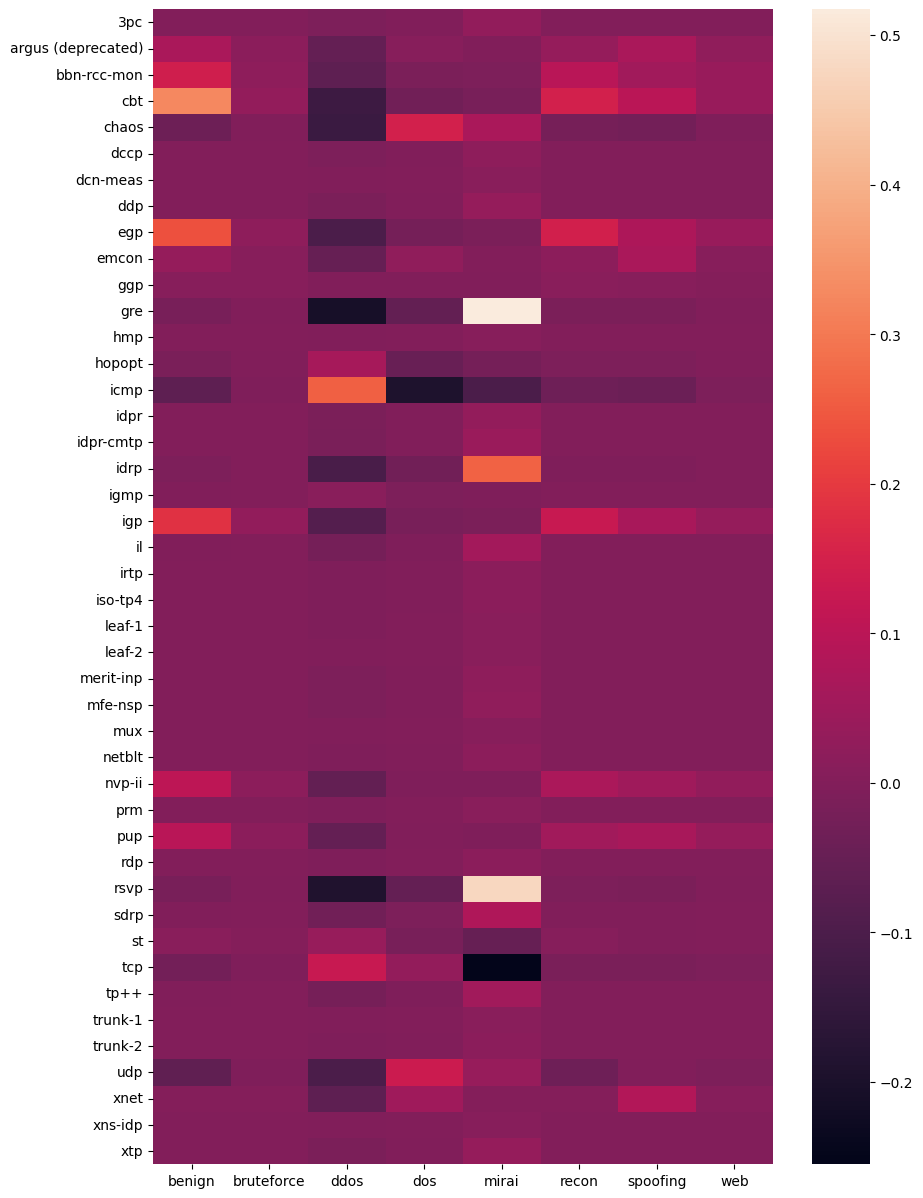

In [11]:
# Note modest correlations at best. Spurious correlations likely included.
# Some justifications for outliers (ex: MIRAI and GRE - https://heimdalsecurity.com/blog/mirai-botnet-phenomenon/)
plt.subplots(figsize=(10,15))
heat = sns.heatmap(corr.iloc[47:,39:47])

In [12]:
heat.get_figure().savefig("/kaggle/working/protocol_vs_attacks.png")

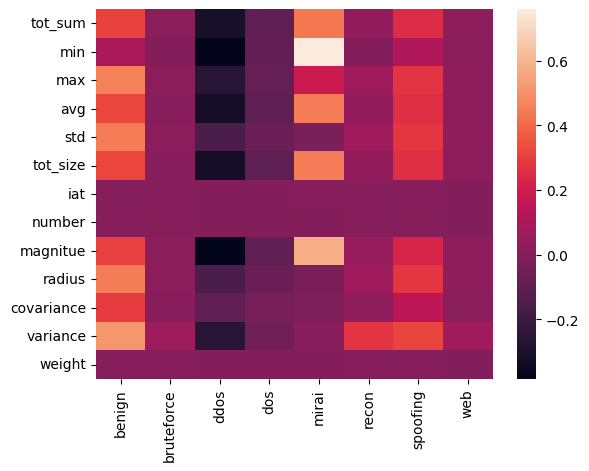

In [13]:
# Compare that to the expert derived features. 
# These are relatively stronger, BUT lack the time dimension. 
# We can see this makes time-related attacks like bruteforcing and DoS harder to predict. 
heat = sns.heatmap(corr.iloc[26:39,39:47])

In [14]:
heat.get_figure().savefig("/kaggle/working/expert_vs_attacks.png")

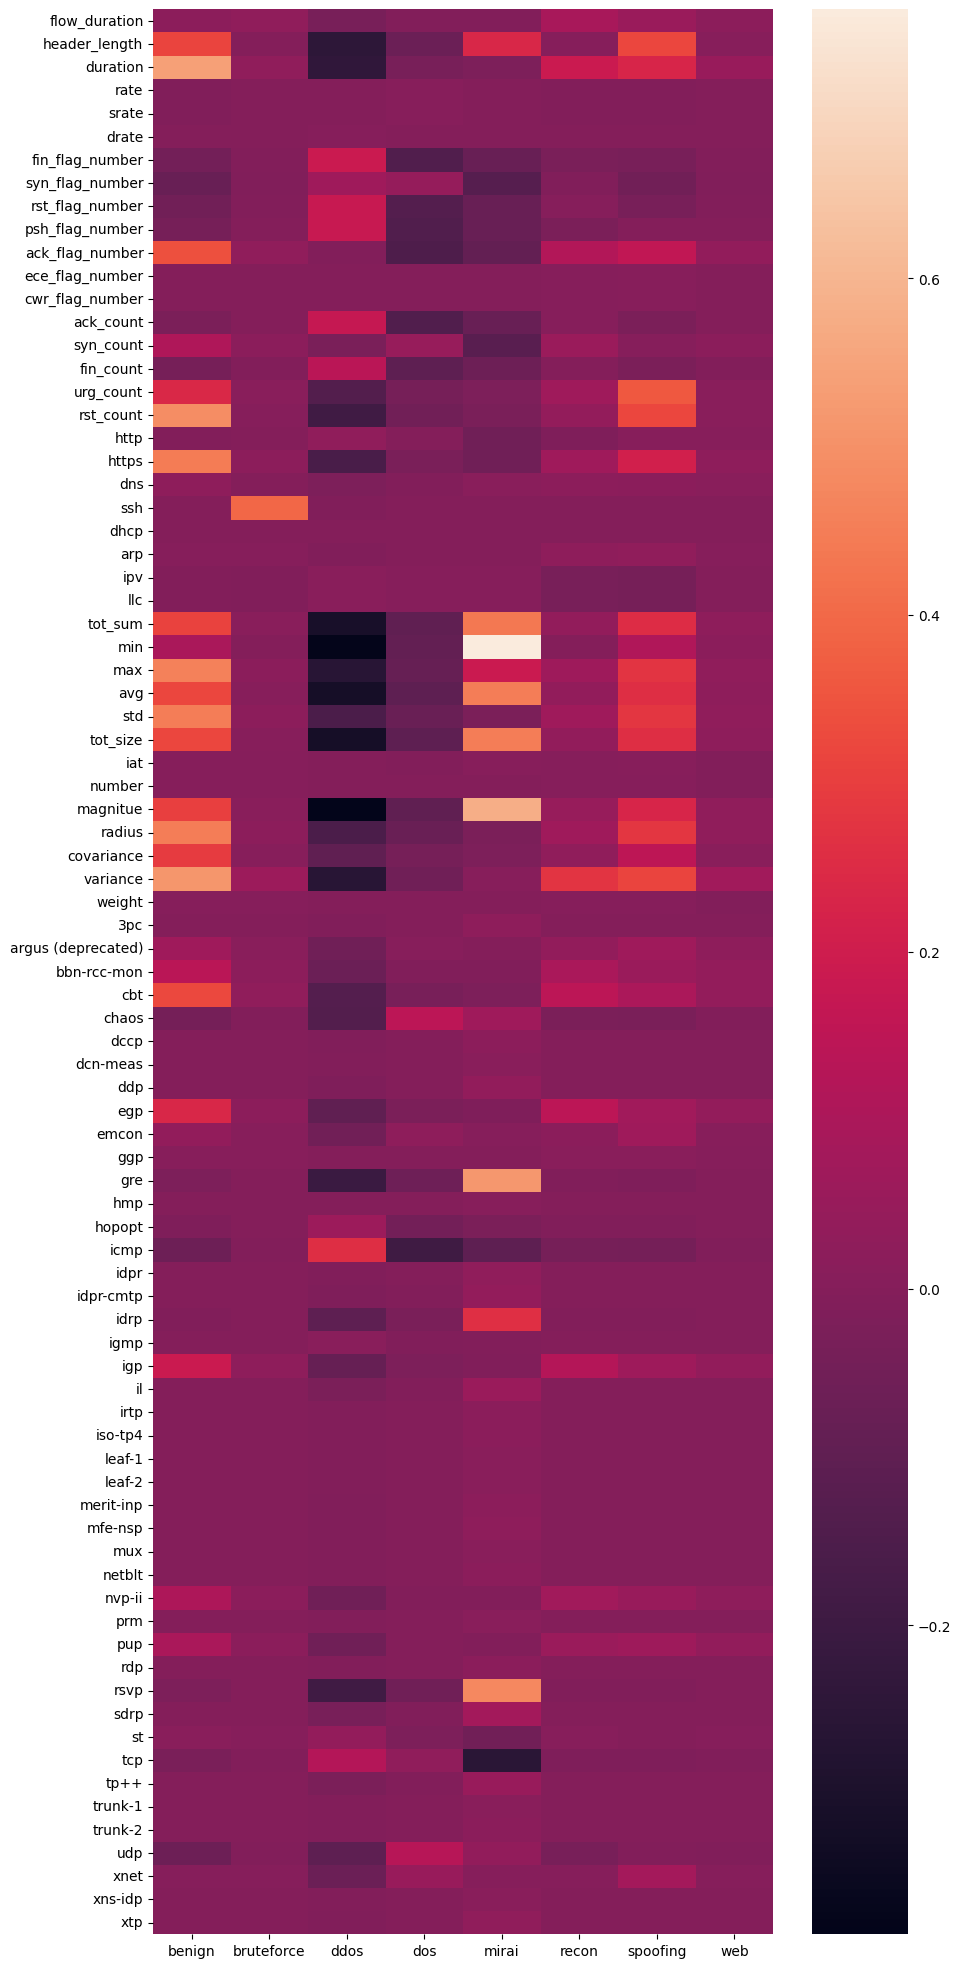

In [15]:
# Finally, here's a visual summary of the earlier numerical table
plt.subplots(figsize=(10,25))
heat = sns.heatmap( corr.drop(corr.index[39:47]).iloc[:, 39:47] )

In [16]:
heat.get_figure().savefig("/kaggle/working/all_features_vs_labels.png")